<div style="display: flex; flex-direction: column; align-items: center; text-align: center; font-family: 'Avenir Next LT Pro', sans-serif; padding: 50px; background-color: #f4f4f4; border-radius: 12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.1);">
    <h1 style="font-size: 50px; font-weight: bold; color: #222; margin-bottom: 10px;">Filologia Digital - Módulo V</h1>
    <h3 style="font-size: 30px; font-weight: bold; color: #555; max-width: 80%; line-height: 1.3;">
        Para além da edição: <span style="font-weight: normal; color: #666;">o digital na investigação linguística</span>
    </h3>
    <h4 style="font-size: 26px; font-weight: bold; color: #333; background-color: #e0e0e0; padding: 10px 20px; border-radius: 8px; margin-top: 25px;">Sessão 5 - Modelling com Léxicos</h4>
    <img src="https://filologiadigitalcl.wordpress.com/wp-content/uploads/2024/11/figure05.png?w=1024" 
         style="width: 80%; max-width: 600px; margin-top: 30px; border-radius: 10px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.15);">
</div>

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f4;
            color: #333;
            margin: 0;
            padding: 20px;
            line-height: 1.6;
        }
        ol {
            counter-reset: section;
            list-style: none;
            padding-left: 0;
        }
        /* First-level list */
        ol > li {
            counter-increment: section;
            margin-bottom: 10px;
            padding-left: 0;
        }
        ol > li::before {
            content: counters(section, ".") " ";
            font-weight: bold;
        }
        /* Second-level list */
        ol ol {
            counter-reset: subsection;
            padding-left: 20px;
            margin-top: 5px;
        }
        ol ol > li {
            counter-increment: subsection;
            margin-bottom: 5px;
            padding-left: 10px;
        }
        ol ol > li::before {
            content: counters(section, ".") "." counter(subsection) " ";
            font-weight: bold;
        }
        /* Third-level list */
        ol ol ol {
            counter-reset: subsubsection;
            padding-left: 40px;
            margin-top: 5px;
        }
        ol ol ol > li {
            counter-increment: subsubsection;
            margin-bottom: 5px;
            padding-left: 10px;
            font-size: 0.9em; /* Make font size smaller */
            font-weight: normal; /* Remove bold styling */
        }
        ol ol ol > li::before {
            content: counters(section, ".") "." counter(subsection) "." counter(subsubsection) " ";
            font-weight: bold;
        }
        a {
            text-decoration: none;
            color: #007BFF;
            font-weight: bold;
        }
        a:hover {
            color: #0056b3;
        }
        footer {
            margin-top: 50px;
        }
    </style>
</head>
<body>

<h2><b>Índice</b></h2>
<ol>
    <li><a href="#1">Setup projeto</a></li>
    <li><a href="#2">Pré-processamento simples</a></li>
    <li><a href="#3">Modelos com léxico de sentimentos</a></li>
        <ol>
            <li><a href="#3.1">NRC Word-Emotion Association Lexicon (aka EmoLex)</a></li>
             <ol>
            <li><a href="#3.1.1">EmoLex Sem tratamento da negação</a></li>
            <li><a href="#3.1.2">EmoLex Com tratamento da negação</a></li>
            </ol>
            <li><a href="#3.2">Vader Lexicon</a></li>
             <ol>
            <li><a href="#3.2.1">Vader Sem tratamento da negação</a></li>
            <li><a href="#3.2.2">Vader Com tratamento da negação</a></li>
            </ol>
            <li><a href="#3.3">Afinn Lexicon</a></li>
             <ol>
            <li><a href="#3.3.1">Afinn Sem tratamento da negação</a></li>
            <li><a href="#3.3.2">Afinn Com tratamento da negação</a></li>
            </ol>
            </ol>
    <li><a href="#4">Comparação de léxicos</a></li>
    <li><a href="#5">Tentativa ao juntar léxicos</a></li>
    <li><a href="#6">Interpretação de resultados com e sem tratamento da negação</a></li>
    
    
</ol>

<footer></footer>

</body>
</html>

# <a class='anchor' id='1'></a>

> # **1. Setup projeto** 

##### Imports

In [26]:
import re
import nltk
import emoji
import unidecode
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TweetTokenizer, TreebankWordTokenizer
from nltk import pos_tag
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import sys
import requests

# Caminho da pasta "root"
base_dir = Path(os.getcwd()).resolve()  # Ajuste se necessário, podes utilizar .parent para subir um nível
data_dir = base_dir / "Data"  # Diretório onde os dados serão armazenados
base_dir

WindowsPath('C:/Users/diogo/Desktop/Filologia_Digital-Modulo_V/Session4')

##### Funções importantes

Nesta fase do modelling, para normalizar os gráficos, será utilizado um ficheiro .py no ``src`` para utilizar em todos os ficheiros notebook referentes ao modelling.

In [27]:
src_dir = base_dir / "src"
src_dir.mkdir(parents=True, exist_ok=True)  # Cria o diretório src se não existir
sys.path.append(str(src_dir))

# Importar os módulos
try:
    from common_functions import preprocess, plot_confusion_matrix, print_classification_report, clean_text
except ImportError:
    print("Erro: Não foi possível importar algum módulo. Verifique se o caminho está correto.")

# Função de classificação sem o tratamento de negação
def classify(tokens, lexicon):
    score = sum(lexicon.get(token, 0) for token in tokens)
    if score >= 0:
        return 'pos'
    else:
        return 'neg'

negation_words = {
    'no', 'not', 'never', 'none', 'nobody', 'nothing', 'neither', 'nowhere',
    "n't", "cannot", "can't", "dont", "don't", "doesn't", "isn't", "wasn't",
    "aren't", "hasn't", "haven't", "hadn't", "won't", "wouldn't", "shouldn't",
    "couldn't", "mightn't", "mustn't", "shan't", "without", "barely", 
    "hardly", "scarcely", "rarely", "seldom", "nor", "can't", "ain't"
}

punctuation = {".", "!", "?", ",", ";" }

# Função de classificação com o tratamento de negação    
def classify_with_negation(tokens, lexicon, negation_words=negation_words, punctuation=punctuation):
    score = 0
    under_negation = False

    for token in tokens:
        token = token.lower()

        if token in negation_words:
            under_negation = True
            continue
        if token in punctuation:
            under_negation = False
            continue
        if token in lexicon:
            sentiment = lexicon[token]
            if under_negation:
                score -= sentiment
            else:
                score += sentiment
    return 'pos' if score >= 0 else 'neg'

> ### 0. Leitura dos dados

In [28]:
DataSetsChosen = "Tweets_EN_sentiment"
Dataset_train, Dataset_test = DataSetsChosen + "_train.csv", DataSetsChosen + "_test.csv"
df_train, df_test = pd.read_csv(data_dir / Dataset_train), pd.read_csv(data_dir / Dataset_test)

df_test

,tweet,text,class
0,1229614408,G Night world,pos
1,1229158792,Morning all just got home from taking my daug...,pos
2,1228398639,thanks for the follow - how are you connected ...,pos
3,1229411644,re: Home Depot...hey! maybe we'll see you ther...,pos
4,1230107823,tak jsem poprve v zivote napsala zpravicku na ...,pos
...,...,...,...
9980,1228266179,Productive day today FTW! Bought/wrapped gifts...,pos
9981,1229022249,Thanks,pos
9982,1229969913,Nice! Thanks for the info,pos
9983,1230580122,"daaaaamn... i shoulda came down there, but you...",neg


# <a class='anchor' id='2'></a>

> # **2. Pré-processamento simples** 

Mesmo pré-processamento dos modelos baseline. 

- Links/urls -> `https`, `www` e URL
- Tirar as Stopwords
- Passagem para minúsculas (**NOTA**: podemos estar a retirar palavras com todas as letras maiuscúlas, que podem indicar intensidade do sentimento)
- Retirar os RT USER, vistos na AED:
    - RT
    - RT:
    - RT USER
    - RT: USER
    - RT USER USER
    - RT: USER USER USER
    - (...)

Também será feito um pré-processamento aos smiles porque ":)" tem um espaço no meio que é necessário tirar nos tokens.

In [29]:
def smile_merge_tokens(tokens):
    new_tokens = []
    i = 0
    while i < len(tokens):
        if tokens[i] == ':' and i + 1 < len(tokens):
            if tokens[i + 1] == ')': # :)
                new_tokens.append(':)')
                i += 2
                continue
            elif tokens[i + 1] == '(': # :(
                new_tokens.append(':(')
                i += 2
                continue
        new_tokens.append(tokens[i])
        i += 1
    return new_tokens

In [30]:
# Descarregar stopwords do NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) - negation_words

df_test['clean_text'] = df_test['text'].astype(str).apply(clean_text, stop_words=stop_words)
df_test.dropna(subset=['text'], inplace=True)
df_test['tokens'] = df_test['clean_text'].apply(preprocess)
df_test['tokens'] = df_test['tokens'].apply(smile_merge_tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
df_test
# df_test[df_test['text'].str.contains(': )', case=False, na=False, regex=False)] # tem os tokens com :) no mesmo token
# df_test[df_test['text'].str.contains(':D', case=False, na=False, regex=False)] # não tem problema

,tweet,text,class,clean_text,tokens
0,1229614408,G Night world,pos,g night world,"[g, night, world]"
1,1229158792,Morning all just got home from taking my daug...,pos,morning got home taking daughter doc's. want m...,"[morning, got, home, taking, daughter, doc's, ..."
2,1228398639,thanks for the follow - how are you connected ...,pos,"thanks follow - connected b&gc? board 6 years,...","[thanks, follow, -, connected, b, &, gc, ?, bo..."
3,1229411644,re: Home Depot...hey! maybe we'll see you ther...,pos,re: home depot...hey! maybe see there... : ),"[re, :, home, depot, ..., hey, !, maybe, see, ..."
4,1230107823,tak jsem poprve v zivote napsala zpravicku na ...,pos,tak jsem poprve v zivote napsala zpravicku na ...,"[tak, jsem, poprve, v, zivote, napsala, zpravi..."
...,...,...,...,...,...
9980,1228266179,Productive day today FTW! Bought/wrapped gifts...,pos,productive day today ftw! bought/wrapped gifts...,"[productive, day, today, ftw, !, bought, /, wr..."
9981,1229022249,Thanks,pos,thanks,[thanks]
9982,1229969913,Nice! Thanks for the info,pos,nice! thanks info,"[nice, !, thanks, info]"
9983,1230580122,"daaaaamn... i shoulda came down there, but you...",neg,"daaaaamn... shoulda came there, cant buy recor...","[daaamn, ..., shoulda, came, there, ,, cant, b..."


Os smiles já se encontram no mesmo token, graças à função `smile_merge_tokens()`. Também foi identificado que os ":D" nos tokens ficam ":d", que não será problema pois no léxico do VADER temos essas duas variações: ":D" e ":d".

In [32]:
def contains_negation(text):
    words = text.split()
    return any(word in negation_words for word in words)

df_negations = df_test[df_test['clean_text'].apply(contains_negation)]
df_negations["clean_text"]

8       new badmaths video (google 'nokia n-gage' firs...
19      beer rocks. bad don't sell right now. im enjoy...
42         no discounts apple store... still packed house
52      could pay let know.... lol ....... sorry, don'...
54      supposed dinner family maleny boy taking age g...
                              ...                        
9941    true, one thing sure. no one copy willy crawfo...
9948    go immigration, clear customs find driver take...
9956    hide wine bottle scrub graffiti wall cus cloys...
9978    hahahaah should! doesn't know are?! tell her, ...
9984    not entirely sure gonna work today. looks like...
Name: clean_text, Length: 1677, dtype: object

# <a class='anchor' id='3'></a>

> # **3. Modelos com léxico de sentimentos** 

In [33]:
dataExternal_dir = data_dir / "external"
dataExternal_dir.mkdir(parents=True, exist_ok=True)  # Cria o diretório external se não existir

# <a class='anchor' id='3.1'></a>

> ## **3.1 NRC Word-Emotion Association Lexicon (aka EmoLex)** 

https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [34]:
# Carregamento do léxico NRC traduzido para português
nrc = pd.read_csv(dataExternal_dir / 'Portuguese-NRC-EmoLex.txt', sep='\t')

# Calcular a pontuação de sentimento como a diferença entre as colunas 'positive' e 'negative'
nrc['sentiment_score'] = nrc['positive'] - nrc['negative']

# Verifica nomes das colunas
nrc.columns = [col.lower() for col in nrc.columns]

# Remover as colunas originais de 'positive' e 'negative'
nrc = nrc[['english word', 'sentiment_score']]

# Converter para dicionário (lookup rápido)
nrc_dict = dict(zip(nrc['english word'], nrc['sentiment_score']))

nrc.head()

,english word,sentiment_score
0,aback,0
1,abacus,0
2,abandon,-1
3,abandoned,-1
4,abandonment,-1


# <a class='anchor' id='3.1.1'></a>

> ### **3.1.1 EmoLex Sem tratamento da negação** 

=== Sem Tratamento da Negação ===


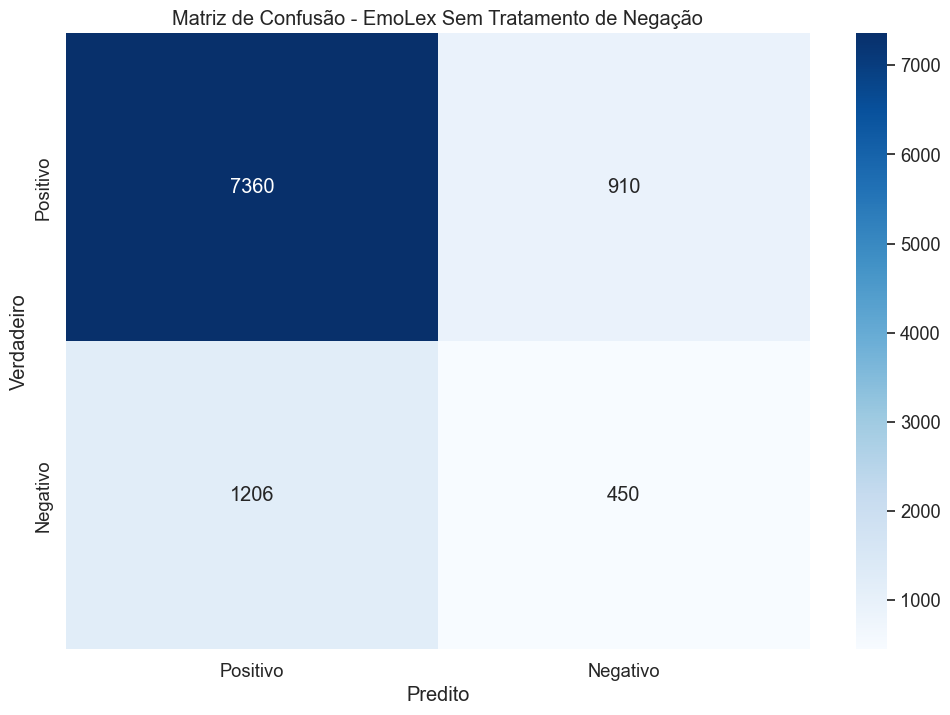


=== Relatório de Desempenho: EmoLex Sem Tratamento de Negação ===
Accuracy : 0.7868
Precisão : 0.8592
Recall   : 0.8900
F1-score : 0.8743

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.33      0.27      0.30      1656
         pos       0.86      0.89      0.87      8270

    accuracy                           0.79      9926
   macro avg       0.60      0.58      0.59      9926
weighted avg       0.77      0.79      0.78      9926



In [35]:
print("=== Sem Tratamento da Negação ===")

# Aplicar o tratamento do lexico nrc
df_test['nrc_prediction'] = df_test['tokens'].apply(lambda x: classify(x, nrc_dict))

plot_confusion_matrix(df_test['class'], df_test['nrc_prediction'], model_name="EmoLex Sem Tratamento de Negação")
print_classification_report(df_test['class'], df_test['nrc_prediction'], model_name="EmoLex Sem Tratamento de Negação")

# <a class='anchor' id='3.1.2'></a>

> ### **3.1.2 EmoLex Com tratamento da negação** 

=== Com Tratamento de Negação ===


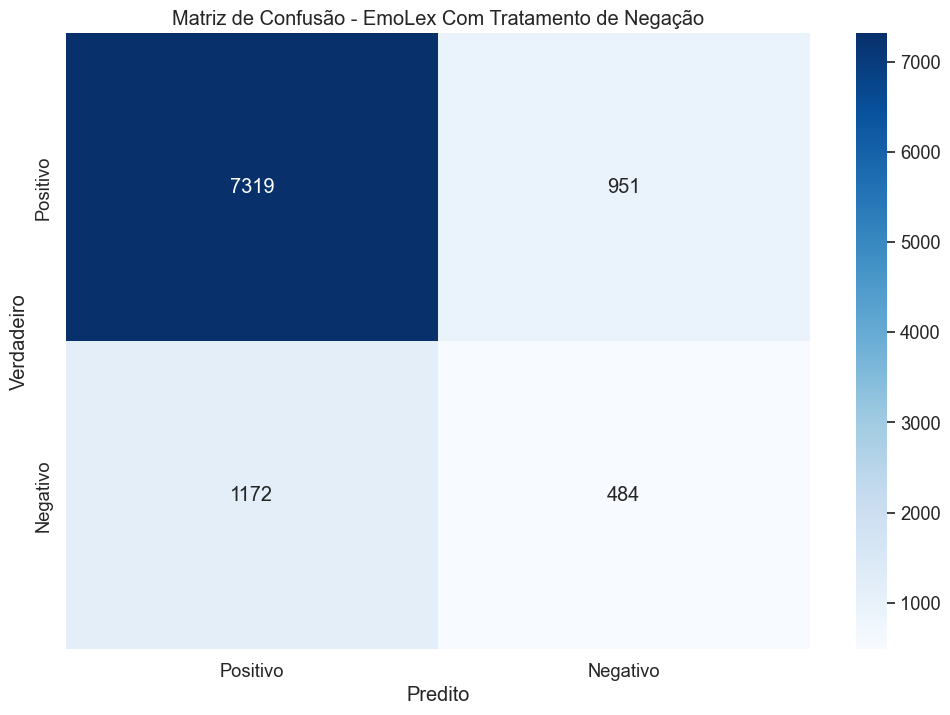


=== Relatório de Desempenho: EmoLex Com Tratamento de Negação ===
Accuracy : 0.7861
Precisão : 0.8620
Recall   : 0.8850
F1-score : 0.8733

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.34      0.29      0.31      1656
         pos       0.86      0.89      0.87      8270

    accuracy                           0.79      9926
   macro avg       0.60      0.59      0.59      9926
weighted avg       0.77      0.79      0.78      9926



In [36]:
print("=== Com Tratamento de Negação ===")

# negation_words = set([word for word, score in nrc_dict.items() if score < 0])

# Aplicar o tratamento de negação
df_test['nrc_prediction_neg'] = df_test['tokens'].apply(lambda x: classify_with_negation(x, nrc_dict, negation_words=negation_words))

plot_confusion_matrix(df_test['class'], df_test['nrc_prediction_neg'], model_name="EmoLex Com Tratamento de Negação")
print_classification_report(df_test['class'], df_test['nrc_prediction_neg'], model_name="EmoLex Com Tratamento de Negação")

# <a class='anchor' id='3.2'></a>

> ## **3.2 Vader Lexicon** 

https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt

https://stackoverflow.com/questions/50882838/python-vader-lexicon-structure-for-sentiment-analysis

In [37]:
# URL do ficheiro VADER Lexicon no GitHub
url = "https://raw.githubusercontent.com/cjhutto/vaderSentiment/master/vaderSentiment/vader_lexicon.txt"

# Caminho onde queres guardar o ficheiro
caminho_local = dataExternal_dir / "vader_lexicon.txt"  # Altera para o teu caminho preferido

# Fazer o download e guardar
response = requests.get(url)

if response.status_code == 200:
    with open(caminho_local, 'w', encoding='utf-8') as f:
        f.write(response.text)
    print(f"Ficheiro guardado em: {caminho_local}")
else:
    print("Erro ao fazer o download:", response.status_code)


Ficheiro guardado em: C:\Users\diogo\Desktop\Filologia_Digital-Modulo_V\Session4\Data\external\vader_lexicon.txt


In [38]:
# Lê o ficheiro com separador de tabulações e sem header
df_vader = pd.read_csv(
    caminho_local,
    sep="\t",
    header=None,
    names=["word", "sentiment_score", "std_dev", "raw_sentiment"]
)

# Visualiza as primeiras linhas
print(df_vader.head())
vader_dict = dict(zip(df_vader['word'], df_vader['sentiment_score'])) # Cria um dicionário com as palavras e os seus scores de sentimento

  word  sentiment_score  std_dev                             raw_sentiment
0   $:             -1.5  0.80623  [-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
1   %)             -0.4  1.01980       [-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
2  %-)             -1.5  1.43178    [-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
3  &-:             -0.4  1.42829      [-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
4   &:             -0.7  0.64031    [0, -1, -1, -1, 1, -1, -1, -1, -1, -1]


Os smiles já se encontram no mesmo token, graças à função `smile_merge_tokens()`. Também foi identificado que os ":D" nos tokens ficam ":d", que não será problema, pois no léxico do VADER temos essas duas variações: ":D" e ":d" com o mesmo valor de polaridade.

In [39]:
print(df_vader[df_vader['word'].isin([':D', ':d'])])

    word  sentiment_score  std_dev                   raw_sentiment
134   :d              2.3      1.1  [4, 2, 2, 1, 2, 1, 4, 3, 3, 1]
135   :D              2.3      1.1  [4, 2, 2, 1, 2, 1, 4, 3, 3, 1]


# <a class='anchor' id='3.2.1'></a>

> ### **3.2.1 Vader Sem tratamento da negação** 

=== Sem Tratamento de Negação ===


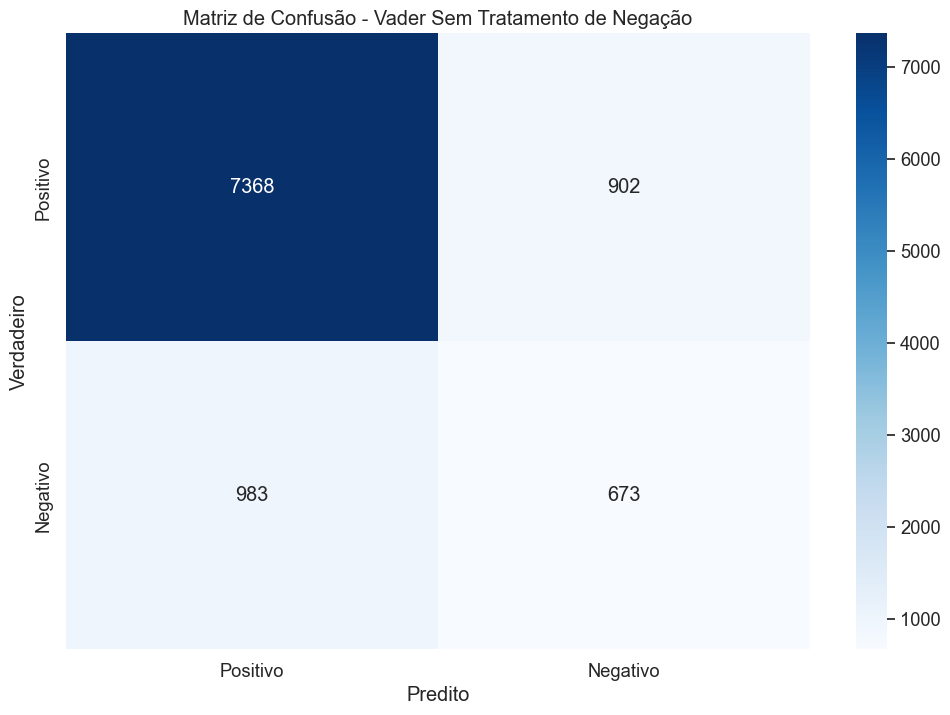


=== Relatório de Desempenho: Vader Sem Tratamento de Negação ===
Accuracy : 0.8101
Precisão : 0.8823
Recall   : 0.8909
F1-score : 0.8866

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.43      0.41      0.42      1656
         pos       0.88      0.89      0.89      8270

    accuracy                           0.81      9926
   macro avg       0.65      0.65      0.65      9926
weighted avg       0.81      0.81      0.81      9926



In [40]:
print("=== Sem Tratamento de Negação ===")

df_test['vader_prediction'] = df_test['tokens'].apply(lambda x: classify(x, vader_dict))

plot_confusion_matrix(df_test['class'], df_test['vader_prediction'], model_name="Vader Sem Tratamento de Negação")
print_classification_report(df_test['class'], df_test['vader_prediction'], model_name="Vader Sem Tratamento de Negação")

# <a class='anchor' id='3.2.2'></a>

> ### **3.2.2 Vader Com tratamento da negação** 

=== Com Tratamento da Negação ===


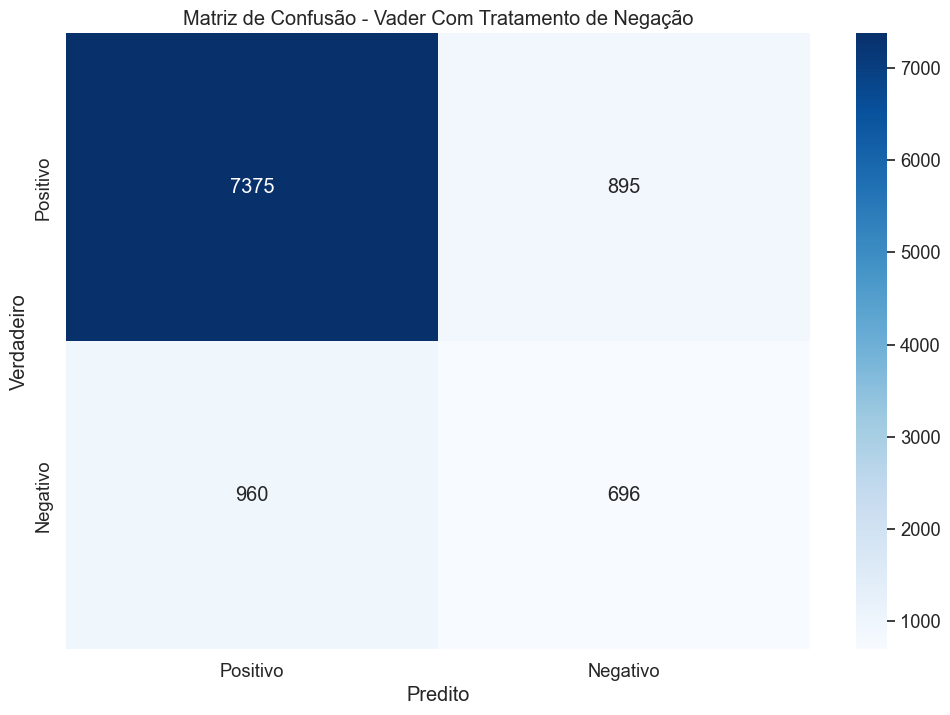


=== Relatório de Desempenho: Vader Com Tratamento de Negação ===
Accuracy : 0.8131
Precisão : 0.8848
Recall   : 0.8918
F1-score : 0.8883

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.44      0.42      0.43      1656
         pos       0.88      0.89      0.89      8270

    accuracy                           0.81      9926
   macro avg       0.66      0.66      0.66      9926
weighted avg       0.81      0.81      0.81      9926



In [41]:
print("=== Com Tratamento da Negação ===")

# negation_words = set([word for word, score in vader_dict.items() if score < 0])

df_test['vader_prediction_neg'] = df_test['tokens'].apply(lambda x: classify_with_negation(x, vader_dict, negation_words=negation_words))

plot_confusion_matrix(df_test['class'], df_test['vader_prediction_neg'], model_name="Vader Com Tratamento de Negação")
print_classification_report(df_test['class'], df_test['vader_prediction_neg'], model_name="Vader Com Tratamento de Negação")

# <a class='anchor' id='3.3'></a>

> ## **3.3 Afinn Lexicon** 

https://github.com/fnielsen/afinn/blob/master/afinn/data/AFINN-en-165.txt

In [42]:
url = "https://raw.githubusercontent.com/fnielsen/afinn/1d6dfd2b2b8a604eafdd2d175b7a682a0ea0217d/afinn/data/AFINN-en-165.txt"
caminho_local = dataExternal_dir / "afinn_lexicon.txt"

response = requests.get(url)

if response.status_code == 200:
    with open(caminho_local, 'w', encoding='utf-8') as f:
        f.write(response.text)
    print(f"Ficheiro guardado em: {caminho_local}")
else:
    print("Erro ao fazer o download:", response.status_code)


Ficheiro guardado em: C:\Users\diogo\Desktop\Filologia_Digital-Modulo_V\Session4\Data\external\afinn_lexicon.txt


In [43]:
# Lê o ficheiro com separador de tabulações e sem header
df_afinn = pd.read_csv(
    caminho_local,
    sep="\t",
    header=None,
    names=["word", "sentiment_score"]
)

# Visualiza as primeiras linhas
print(df_afinn.head())
affin_dict = dict(zip(df_afinn['word'], df_afinn['sentiment_score'])) # Cria um dicionário com as palavras e os seus scores de sentimento

        word  sentiment_score
0    abandon               -2
1  abandoned               -2
2   abandons               -2
3   abducted               -2
4  abduction               -2


# <a class='anchor' id='3.3.1'></a>

> ### **3.3.1 Afinn Sem tratamento da negação** 

=== Sem Tratamento de Negação ===


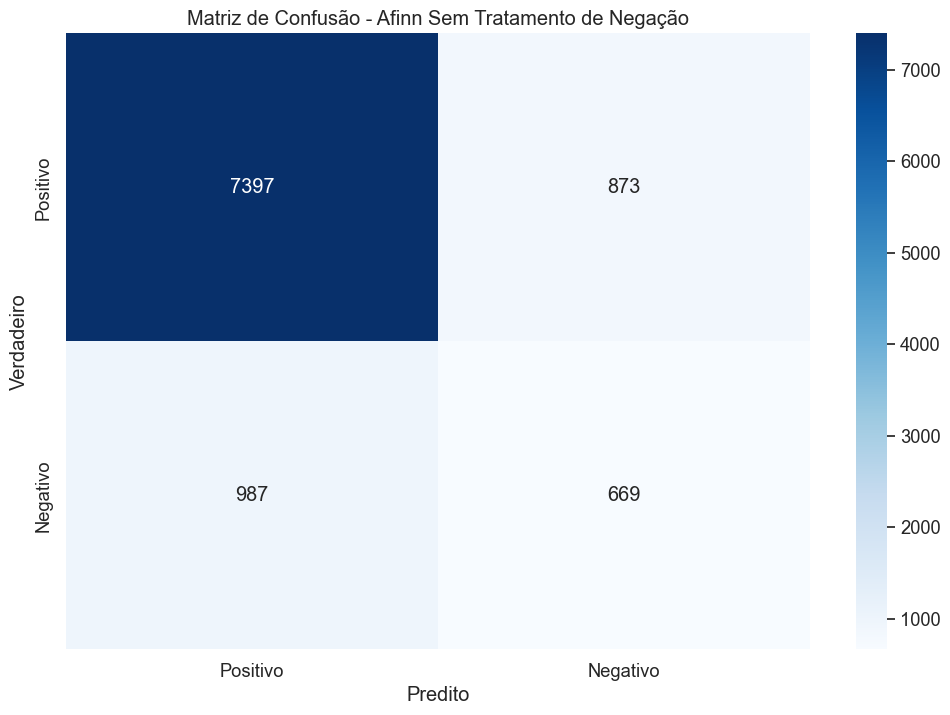


=== Relatório de Desempenho: Afinn Sem Tratamento de Negação ===
Accuracy : 0.8126
Precisão : 0.8823
Recall   : 0.8944
F1-score : 0.8883

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.43      0.40      0.42      1656
         pos       0.88      0.89      0.89      8270

    accuracy                           0.81      9926
   macro avg       0.66      0.65      0.65      9926
weighted avg       0.81      0.81      0.81      9926



In [44]:
print("=== Sem Tratamento de Negação ===")

df_test['affin_prediction'] = df_test['tokens'].apply(lambda x: classify(x, affin_dict))

plot_confusion_matrix(df_test['class'], df_test['affin_prediction'], model_name="Afinn Sem Tratamento de Negação")
print_classification_report(df_test['class'], df_test['affin_prediction'], model_name="Afinn Sem Tratamento de Negação")

# <a class='anchor' id='3.3.2'></a>

> ### **3.3.2 Afinn Com tratamento da negação** 

=== Com Tratamento da Negação ===


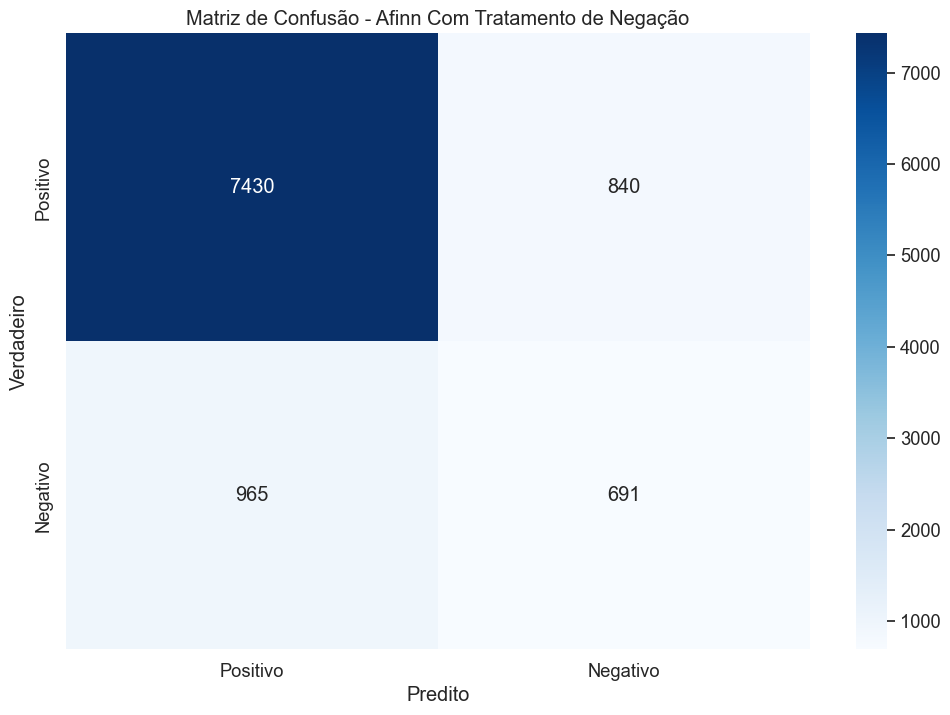


=== Relatório de Desempenho: Afinn Com Tratamento de Negação ===
Accuracy : 0.8182
Precisão : 0.8851
Recall   : 0.8984
F1-score : 0.8917

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.45      0.42      0.43      1656
         pos       0.89      0.90      0.89      8270

    accuracy                           0.82      9926
   macro avg       0.67      0.66      0.66      9926
weighted avg       0.81      0.82      0.82      9926



In [45]:
print("=== Com Tratamento da Negação ===")

# negation_words = set([word for word, score in affin_dict.items() if score < 0])

df_test['affin_prediction_neg'] = df_test['tokens'].apply(lambda x: classify_with_negation(x, affin_dict, negation_words=negation_words))

plot_confusion_matrix(df_test['class'], df_test['affin_prediction_neg'], model_name="Afinn Com Tratamento de Negação")
print_classification_report(df_test['class'], df_test['affin_prediction_neg'], model_name="Afinn Com Tratamento de Negação")

# <a class='anchor' id='4'></a>

> # **4 Comparação de léxicos** 

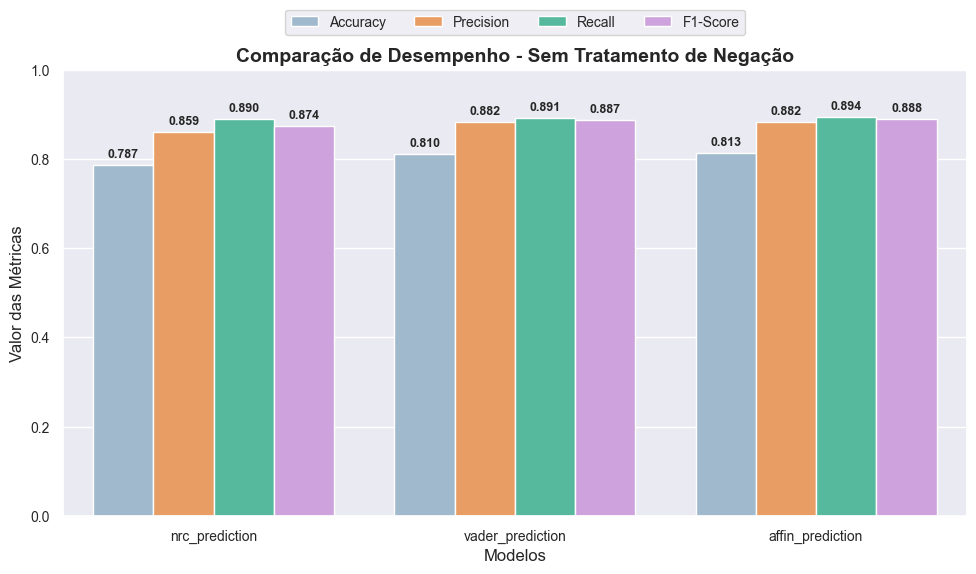

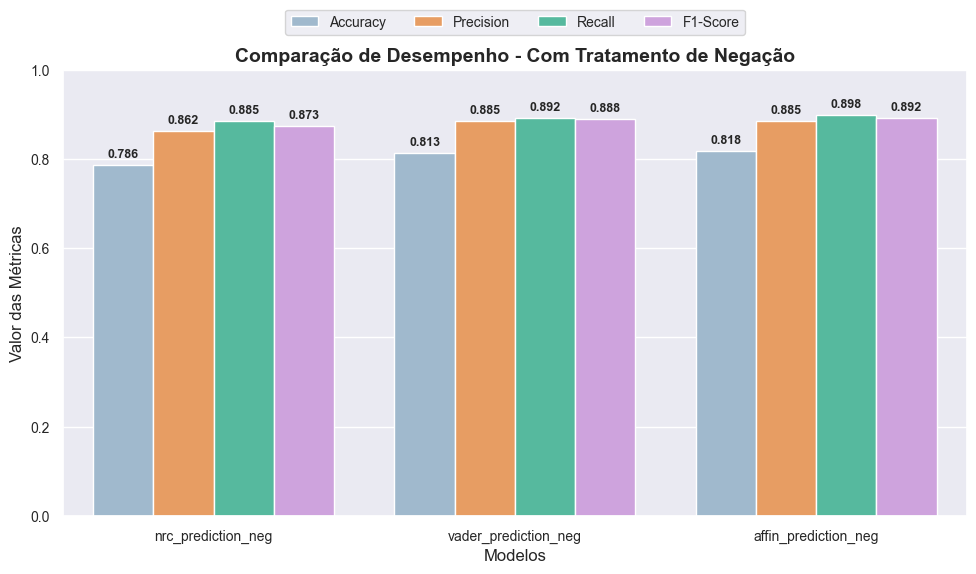

In [46]:
# Separar os modelos de previsão positiva e negativa
models_pos = ['nrc_prediction', 'vader_prediction', 'affin_prediction']
models_neg = ['nrc_prediction_neg', 'vader_prediction_neg', 'affin_prediction_neg']

def calcular_metricas(df, modelos, label_pos):
    acc = {}
    prec = {}
    rec = {}
    f1 = {}

    for model in modelos:
        acc[model] = accuracy_score(df['class'], df[model])
        prec[model] = precision_score(df['class'], df[model], pos_label=label_pos)
        rec[model] = recall_score(df['class'], df[model], pos_label=label_pos)
        f1[model] = f1_score(df['class'], df[model], pos_label=label_pos)

    metrics_df = pd.DataFrame({
        'Model': modelos,
        'Accuracy': acc.values(),
        'Precision': prec.values(),
        'Recall': rec.values(),
        'F1-Score': f1.values()
    })
    return metrics_df

custom_palette = ['#98BAD5', '#FD9A4D', '#45CAA5', '#D39AE6']

def plot_metrics(metrics_df, titulo):
    metrics_long = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_long, palette=custom_palette)

    plt.title(titulo, fontsize=14, weight='bold')
    plt.ylabel('Valor das Métricas', fontsize=12)
    plt.xlabel('Modelos', fontsize=12)
    plt.ylim(0, 1)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height) and height > 0:
            ax.text(
                x=p.get_x() + p.get_width() / 2,
                y=height + 0.01,
                s=f'{height:.3f}',
                ha='center',
                va='bottom',
                fontsize=9,
                weight='bold'
            )

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=10)
    plt.tight_layout()
    plt.show()

# Cálculo e visualização para previsões positivas
metrics_pos = calcular_metricas(df_test, models_pos, label_pos="pos")
plot_metrics(metrics_pos, 'Comparação de Desempenho - Sem Tratamento de Negação')

# Cálculo e visualização para previsões negativas
metrics_neg = calcular_metricas(df_test, models_neg, label_pos="pos")
plot_metrics(metrics_neg, 'Comparação de Desempenho - Com Tratamento de Negação')

# <a class='anchor' id='5'></a>

> # **5 Tentativa ao juntar léxicos** 

Vamos juntar dois léxicos para tentar melhorar os resultados, apesar de acharmos que poderá não afetar em quase nada.

```python
df_vader # varia entre -4 e 4

In [47]:
# put the column name with another name
nrc.rename(columns={'english word': 'word', 'sentiment_score': 'sentiment_score_nrc'}, inplace=True)
df_vader.rename(columns={'word': 'word', 'sentiment_score': 'sentiment_score_vader'}, inplace=True)

In [48]:
palavras_em_comum = pd.merge(nrc, df_vader, on='word', how='outer')
palavras_em_comum = palavras_em_comum[['word', 'sentiment_score_nrc', 'sentiment_score_vader']]

palavras_em_comum

,word,sentiment_score_nrc,sentiment_score_vader
0,$:,NaN,-1.5
1,%),NaN,-0.4
2,%-),NaN,-1.5
3,&-:,NaN,-0.4
4,&:,NaN,-0.7
...,...,...,...
19839,}:(,NaN,-2.0
19840,}:),NaN,0.4
19841,}:-(,NaN,-2.1
19842,}:-),NaN,0.3


In [49]:
# Palavras que têm sinal de polaridade diferente
palavras_em_comum['polaridade_diferente'] = palavras_em_comum['sentiment_score_nrc'] * palavras_em_comum['sentiment_score_vader'] < 0
palavras_em_comum[palavras_em_comum['polaridade_diferente'] == True]

,word,sentiment_score_nrc,sentiment_score_vader,polaridade_diferente
2758,cautious,1.0,-0.4,True
2833,challenge,-1.0,0.3,True
6432,excuse,-1.0,0.3,True
10006,joke,-1.0,1.2,True
10338,laughable,-1.0,0.2,True
12517,overwhelmed,-1.0,0.2,True
12728,passive,-1.0,0.8,True
12781,pay,1.0,-0.4,True
12816,peculiarities,-1.0,0.1,True
13629,pretending,-1.0,0.4,True


In [50]:
def ajustar_polaridade(row, estrategia):
    nrc_score = row['sentiment_score_nrc']
    vader_score = row['sentiment_score_vader']
    if nrc_score * vader_score < 0: 
        if estrategia == 'neutra':
            return 0  # palavra passa a neutra
        elif estrategia == 'normalizada':
            normalized_vader_score = vader_score / 4  # normalizar de [-4, 4] para o intervalo [-1, 1]
            return round(nrc_score + normalized_vader_score, 3)
        elif estrategia == 'soma':
            return round(nrc_score + vader_score, 3)  # somar os scores normalmente
    else:
        return vader_score / 4  # TODO: Mudar isto depois myb!!!!!

def calcular_sentiment_score_global(row, estrategia):
    nrc_score = row['sentiment_score_nrc']
    vader_score = row['sentiment_score_vader']
    
    if pd.isna(nrc_score):  # Se o score NRC for nulo, usar o score do Vader
        return vader_score
    elif pd.isna(vader_score):  # Se o score Vader for nulo, usar o score do NRC
        return nrc_score
    else:
        if (nrc_score >= 0 and vader_score >= 0):  # Ambos positivos
            return 1
        elif (nrc_score < 0 and vader_score < 0):  # Ambos negativos
            return -1
        elif nrc_score == 0 and vader_score == 0:  # Ambos zero
            return 0
        else: 
            return ajustar_polaridade(row, estrategia)

In [51]:
estrategia = 'neutra' # pode ser 'neutra', 'normalizada' ou 'soma'
palavras_em_comum['sentiment_score_global'] = palavras_em_comum.apply(lambda row: calcular_sentiment_score_global(row, estrategia), axis=1)

In [52]:
# Palavras que têm sinal de polaridade diferente
palavras_em_comum['polaridade_diferente'] = palavras_em_comum['sentiment_score_nrc'] * palavras_em_comum['sentiment_score_vader'] < 0
print(palavras_em_comum[palavras_em_comum['polaridade_diferente'] == True])
df_two_lexicons = dict(zip(palavras_em_comum['word'], palavras_em_comum['sentiment_score_global']))
df_two_lexicons

                word  sentiment_score_nrc  sentiment_score_vader  \
2758        cautious                  1.0                   -0.4   
2833       challenge                 -1.0                    0.3   
6432          excuse                 -1.0                    0.3   
10006           joke                 -1.0                    1.2   
10338      laughable                 -1.0                    0.2   
12517    overwhelmed                 -1.0                    0.2   
12728        passive                 -1.0                    0.8   
12781            pay                  1.0                   -0.4   
12816  peculiarities                 -1.0                    0.1   
13629     pretending                 -1.0                    0.4   
15646       sentence                 -1.0                    0.3   
15686         serene                 -1.0                    2.0   
15985          silly                 -1.0                    0.1   
16088           slap                 -1.0       

{'$:': -1.5,
 '%)': -0.4,
 '%-)': -1.5,
 '&-:': -0.4,
 '&:': -0.7,
 "( '}{' )": 1.6,
 '(%': -0.9,
 "('-:": 2.2,
 "(':": 2.3,
 '((-:': 2.1,
 '(*': 1.1,
 '(-%': -0.7,
 '(-*': 1.3,
 '(-:': 1.6,
 '(-:0': 2.8,
 '(-:<': -0.4,
 '(-:O': 1.5,
 '(-:o': 1.5,
 '(-:{': -0.1,
 '(-:|>*': 1.9,
 '(-;': 1.3,
 '(-;|': 2.1,
 '(8': 2.6,
 '(:': 2.2,
 '(:0': 2.4,
 '(:<': -0.2,
 '(:O': 2.5,
 '(:o': 2.5,
 '(;': 1.1,
 '(;<': 0.3,
 '(=': 2.2,
 '(?:': 2.1,
 '(^:': 1.5,
 '(^;': 1.5,
 '(^;0': 2.0,
 '(^;o': 1.9,
 '(o:': 1.6,
 ")':": -2.0,
 ")-':": -2.1,
 ')-:': -2.1,
 ')-:<': -2.2,
 ')-:{': -2.1,
 '):': -1.8,
 '):<': -1.9,
 '):{': -2.3,
 ');<': -2.6,
 '*)': 0.6,
 '*-)': 0.3,
 '*-:': 2.1,
 '*-;': 2.4,
 '*:': 1.9,
 '*<|:-)': 1.6,
 '*\\0/*': 2.3,
 '*^:': 1.6,
 ',-:': 1.2,
 "---'-;-{@": 2.3,
 '--<--<@': 2.2,
 '.-:': -1.2,
 '..###-:': -1.7,
 '..###:': -1.9,
 '/-:': -1.3,
 '/:': -1.3,
 '/:<': -1.4,
 '/=': -0.9,
 '/^:': -1.0,
 '/o:': -1.4,
 '0-8': 0.1,
 '0-|': -1.2,
 '0:)': 1.9,
 '0:-)': 1.4,
 '0:-3': 1.5,
 '0:03': 1.9,
 '

=== Sem Tratamento da Negação ===


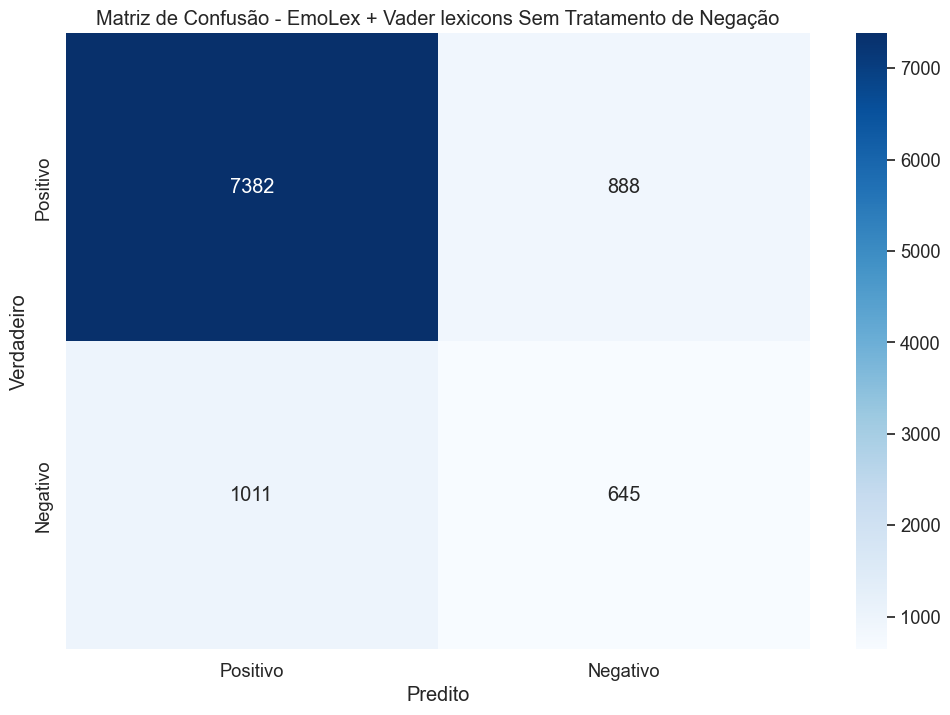


=== Relatório de Desempenho: EmoLex + Vader lexicons Sem Tratamento de Negação ===
Accuracy : 0.8087
Precisão : 0.8795
Recall   : 0.8926
F1-score : 0.8860

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.42      0.39      0.40      1656
         pos       0.88      0.89      0.89      8270

    accuracy                           0.81      9926
   macro avg       0.65      0.64      0.65      9926
weighted avg       0.80      0.81      0.81      9926



In [53]:
print("=== Sem Tratamento da Negação ===")

df_test['two_lexicons_pred'] = df_test['tokens'].apply(lambda x: classify(x, df_two_lexicons))

plot_confusion_matrix(df_test['class'], df_test['two_lexicons_pred'], model_name="EmoLex + Vader lexicons Sem Tratamento de Negação")
print_classification_report(df_test['class'], df_test['two_lexicons_pred'], model_name="EmoLex + Vader lexicons Sem Tratamento de Negação")

=== Com Tratamento da Negação ===


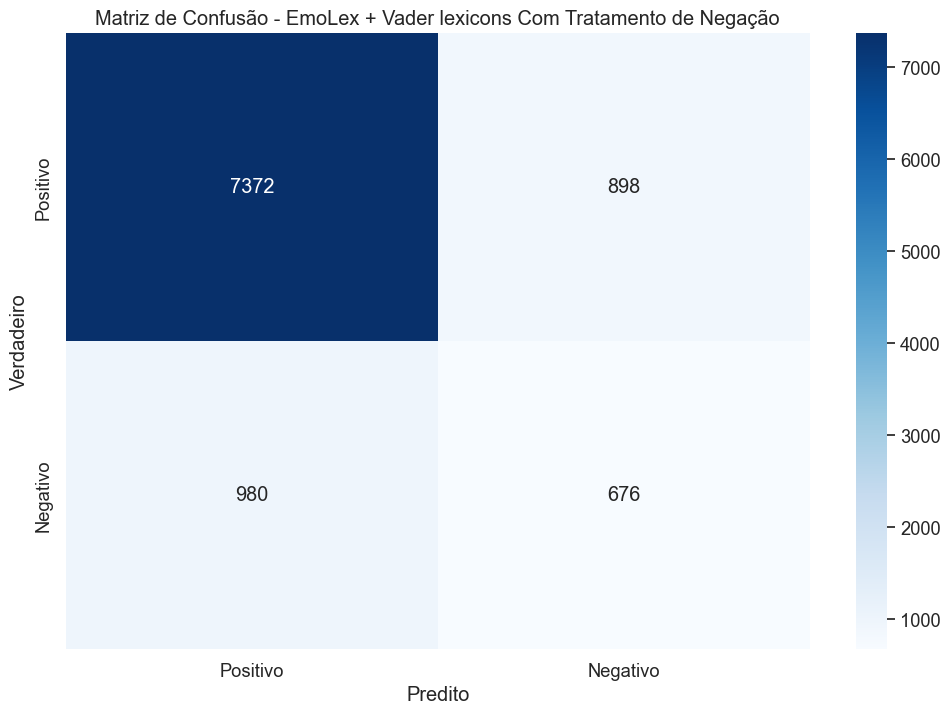


=== Relatório de Desempenho: EmoLex + Vader lexicons Com Tratamento de Negação ===
Accuracy : 0.8108
Precisão : 0.8827
Recall   : 0.8914
F1-score : 0.8870

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.43      0.41      0.42      1656
         pos       0.88      0.89      0.89      8270

    accuracy                           0.81      9926
   macro avg       0.66      0.65      0.65      9926
weighted avg       0.81      0.81      0.81      9926



In [54]:
print("=== Com Tratamento da Negação ===")

df_test['two_lexicons_pred_neg'] = df_test['tokens'].apply(lambda x: classify_with_negation(x, df_two_lexicons, negation_words=negation_words))

plot_confusion_matrix(df_test['class'], df_test['two_lexicons_pred_neg'], model_name="EmoLex + Vader lexicons Com Tratamento de Negação")
print_classification_report(df_test['class'], df_test['two_lexicons_pred_neg'], model_name="EmoLex + Vader lexicons Com Tratamento de Negação")

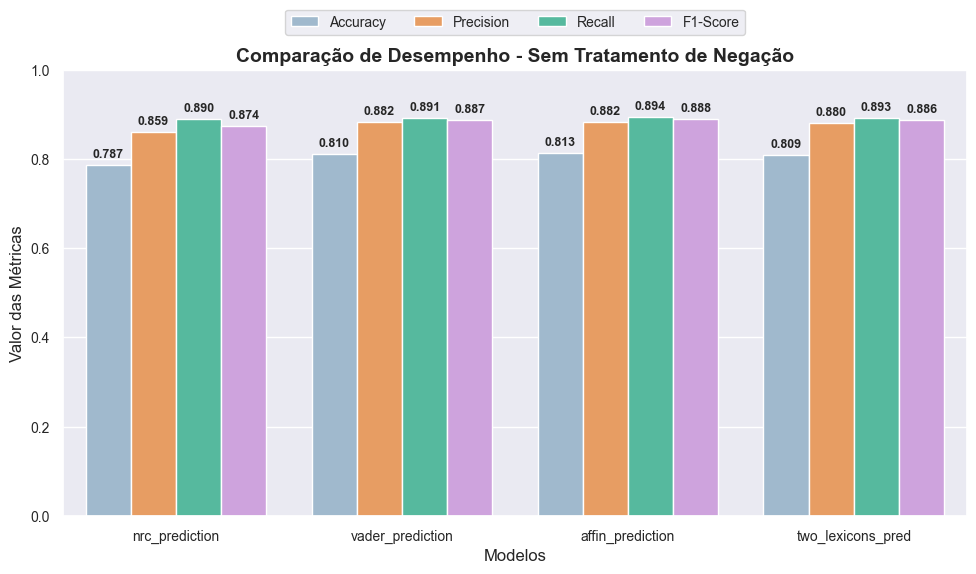

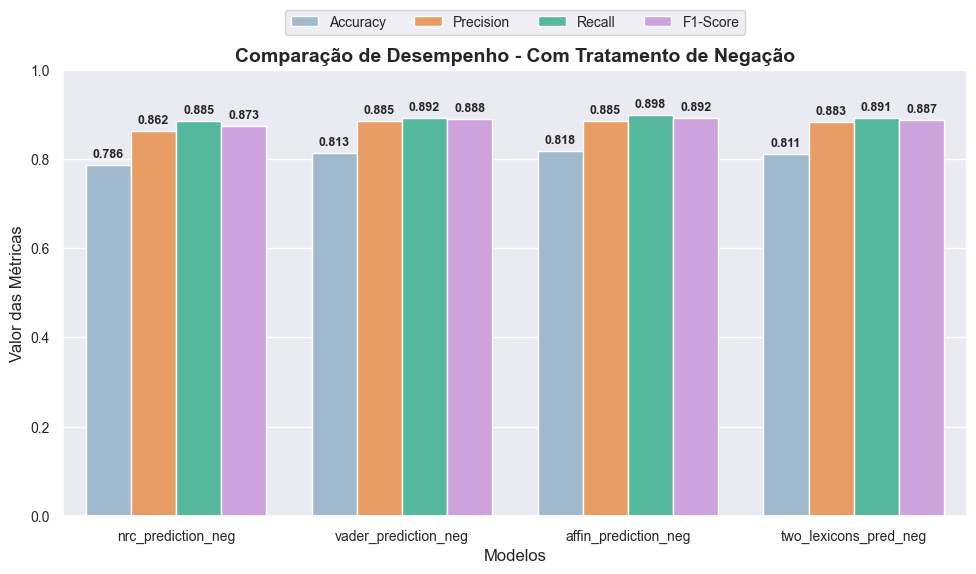

In [55]:
models_pos = ['nrc_prediction', 'vader_prediction', 'affin_prediction', 'two_lexicons_pred']
models_neg = ['nrc_prediction_neg', 'vader_prediction_neg', 'affin_prediction_neg', 'two_lexicons_pred_neg']

# Cálculo e visualização para previsões positivas
metrics_pos = calcular_metricas(df_test, models_pos, label_pos="pos")
plot_metrics(metrics_pos, 'Comparação de Desempenho - Sem Tratamento de Negação')

# Cálculo e visualização para previsões negativas
metrics_neg = calcular_metricas(df_test, models_neg, label_pos="pos")
plot_metrics(metrics_neg, 'Comparação de Desempenho - Com Tratamento de Negação')

# <a class='anchor' id='6'></a>

> # **6 Interpretação de resultados com e sem tratamento da negação** 

Para esta secção vamos comparar os resultados antes e depois do tratamento da negação (relembrar que o pré-processamento feito foi o mesmo). Para isso, vamos selecionar, para cada um dos léxicos, aqueles casos em que o léxico classifica como positivo e depois do tratamento da negação muda para negativo.

Será criado um dataframe com estes casos e adicionada um coluna que referencia os léxicos em que ocorre. (**PK: source + text**)

In [56]:
# df_test
nrc_mismatch = df_test[(df_test['nrc_prediction'] == 'pos') & (df_test['nrc_prediction_neg'] == 'neg')][['text', 'tokens', 'class', 'nrc_prediction', 'nrc_prediction_neg']]
vader_mismatch = df_test[(df_test['vader_prediction'] == 'pos') & (df_test['vader_prediction_neg'] == 'neg')][['text', 'tokens', 'class', 'vader_prediction', 'vader_prediction_neg']]
affin_mismatch = df_test[(df_test['affin_prediction'] == 'pos') & (df_test['affin_prediction_neg'] == 'neg')][['text', 'tokens', 'class', 'affin_prediction', 'affin_prediction_neg']]
two_lexicons_mismatch = df_test[(df_test['two_lexicons_pred'] == 'pos') & (df_test['two_lexicons_pred_neg'] == 'neg')][['text', 'tokens', 'class', 'two_lexicons_pred', 'two_lexicons_pred_neg']]

nrc_mismatch['source'] = 'nrc'
vader_mismatch['source'] = 'vader'
affin_mismatch['source'] = 'affin'
two_lexicons_mismatch['source'] = 'two_lexicons'

all_mismatches = pd.concat([
    nrc_mismatch.rename(columns={'nrc_prediction': 'prediction', 'nrc_prediction_neg': 'prediction_neg'}),
    vader_mismatch.rename(columns={'vader_prediction': 'prediction', 'vader_prediction_neg': 'prediction_neg'}),
    affin_mismatch.rename(columns={'affin_prediction': 'prediction', 'affin_prediction_neg': 'prediction_neg'}),
    two_lexicons_mismatch.rename(columns={'two_lexicons_pred': 'prediction', 'two_lexicons_pred_neg': 'prediction_neg'}),
], ignore_index=True)



all_mismatches = pd.DataFrame(all_mismatches)

all_mismatches.sort_values(by='text', inplace=True)
all_mismatches

,text,tokens,class,prediction,prediction_neg,source
982,Not working,"[not, working]",neg,pos,neg,two_lexicons
116,Not working,"[not, working]",neg,pos,neg,nrc
176,"that is a bigger upset...make you hear it, bu...","[bigger, upset, ..., make, hear, it, ,, not, g...",pos,pos,neg,nrc
1061,"that is a bigger upset...make you hear it, bu...","[bigger, upset, ..., make, hear, it, ,, not, g...",pos,pos,neg,two_lexicons
77,"""Never take life seriously. Nobody gets out al...","["", never, take, life, seriously, ., nobody, g...",pos,pos,neg,nrc
...,...,...,...,...,...,...
1017,"yup, but not as cool as using your SSID to cha...","[yup, ,, not, cool, using, ssid, chat, people]",pos,pos,neg,two_lexicons
146,"yup, but not as cool as using your SSID to cha...","[yup, ,, not, cool, using, ssid, chat, people]",pos,pos,neg,nrc
711,"yup, but not as cool as using your SSID to cha...","[yup, ,, not, cool, using, ssid, chat, people]",pos,pos,neg,affin
410,"yup, but not as cool as using your SSID to cha...","[yup, ,, not, cool, using, ssid, chat, people]",pos,pos,neg,vader


Agora vemos o rácio dos casos em que os léxicos alteram de positivo para negativo de forma incorreta. Ou seja, em que a classe verdadeira é positiva e ele mudou para negativa depois de fazer a negação. As percentagens vão assumir valores bastante altos.

In [57]:
results = []

for source in all_mismatches['source'].unique():
    df = all_mismatches[all_mismatches['source'] == source]
    total = len(df)
    pos_count = (df['class'] == 'pos').sum()
    neg_count = (df['class'] == 'neg').sum()
    ratio_pos = pos_count / total # if neg_count != 0 else float('inf')
    ratio_neg = neg_count / total # if neg_count != 0 else float('inf')

    results.append({
        'source': source,
        'pos_in_class(Changed to wrong classification)': pos_count,
        'total_cases(pos to neg)': total,
        # 'negatives_in_class': neg_count,
        'pos(TRUE)/total': round(ratio_pos,3),
        #'neg(TRUE)/total': ratio_neg
    })

summary_df = pd.DataFrame(results)
summary_df

,source,pos_in_class(Changed to wrong classification),total_cases(pos to neg),pos(TRUE)/total
0,two_lexicons,225,334,0.674
1,nrc,178,253,0.704
2,vader,210,313,0.671
3,affin,178,281,0.633


In [58]:
# selecionar os neg em class 
all_mismatches_neg = all_mismatches[all_mismatches['class'] == 'neg']
all_mismatches_neg

,text,tokens,class,prediction,prediction_neg,source
982,Not working,"[not, working]",neg,pos,neg,two_lexicons
116,Not working,"[not, working]",neg,pos,neg,nrc
71,"$99 iPhone in WalMart, not true. URL","[$, 99, iphone, walmart, ,, not, true, .]",neg,pos,neg,nrc
931,"$99 iPhone in WalMart, not true. URL","[$, 99, iphone, walmart, ,, not, true, .]",neg,pos,neg,two_lexicons
331,"$99 iPhone in WalMart, not true. URL","[$, 99, iphone, walmart, ,, not, true, .]",neg,pos,neg,vader
...,...,...,...,...,...,...
212,"while i'd love the recipes, I'm actually not t...","[love, recipes, ,, actually, not, great, bakin...",neg,pos,neg,nrc
126,will have to read that one later. Can't imagin...,"[read, one, later, ., can't, imagine, would, l...",neg,pos,neg,nrc
385,will have to read that one later. Can't imagin...,"[read, one, later, ., can't, imagine, would, l...",neg,pos,neg,vader
686,will have to read that one later. Can't imagin...,"[read, one, later, ., can't, imagine, would, l...",neg,pos,neg,affin


Nos exemplos:
- "this has not been a good week for you." -> ['not', 'good', 'week', 'you', '.']
- "we suppose to host 2011 world cup..... I am not talking about winning and all"  -> ['suppose', 'host', '2011', 'world', 'cup', '...', 'not', 'talking', 'winning']


conseguimos perceber que os 4 léxicos previram a classe positiva e, depois do tratamento da negação, passaram para a classe negativa. No fundo, a soma da polaridade das palavras positivas é superior ao de negativas, contudo, as `negation_words` mudam a polaridade/sentido da frase. 

Vamos descodificar o que aconteceu em exemplos práticos:

Agora veremos os casos inversos, ou seja, que passou de neg para pos.

In [59]:
nrc_mismatch_inv = df_test[(df_test['nrc_prediction'] == 'neg') & (df_test['nrc_prediction_neg'] == 'pos')][['text', 'tokens', 'class', 'nrc_prediction', 'nrc_prediction_neg']]
vader_mismatch_inv = df_test[(df_test['vader_prediction'] == 'neg') & (df_test['vader_prediction_neg'] == 'pos')][['text', 'tokens', 'class', 'vader_prediction', 'vader_prediction_neg']]
affin_mismatch_inv = df_test[(df_test['affin_prediction'] == 'neg') & (df_test['affin_prediction_neg'] == 'pos')][['text', 'tokens', 'class', 'affin_prediction', 'affin_prediction_neg']]
two_lexicons_mismatch_inv = df_test[(df_test['two_lexicons_pred'] == 'neg') & (df_test['two_lexicons_pred_neg'] == 'pos')][['text', 'tokens', 'class', 'two_lexicons_pred', 'two_lexicons_pred_neg']]

nrc_mismatch_inv['source'] = 'nrc'
vader_mismatch_inv['source'] = 'vader'
affin_mismatch_inv['source'] = 'affin'
two_lexicons_mismatch_inv['source'] = 'two_lexicons'

all_mismatches_inv = pd.concat([
    nrc_mismatch_inv.rename(columns={'nrc_prediction': 'prediction', 'nrc_prediction_neg': 'prediction_neg'}),
    vader_mismatch_inv.rename(columns={'vader_prediction': 'prediction', 'vader_prediction_neg': 'prediction_neg'}),
    affin_mismatch_inv.rename(columns={'affin_prediction': 'prediction', 'affin_prediction_neg': 'prediction_neg'}),
    two_lexicons_mismatch_inv.rename(columns={'two_lexicons_pred': 'prediction', 'two_lexicons_pred_neg': 'prediction_neg'}),
], ignore_index=True)



all_mismatches_inv = pd.DataFrame(all_mismatches_inv)

all_mismatches_inv.sort_values(by='text', inplace=True)
all_mismatches_inv

,text,tokens,class,prediction,prediction_neg,source
136,I was just thinking that I wish I had some of...,"[thinking, wish, silly, rubber, boots, always,...",neg,neg,pos,nrc
697,I was just thinking that I wish I had some of...,"[thinking, wish, silly, rubber, boots, always,...",neg,neg,pos,affin
997,I was just thinking that I wish I had some of...,"[thinking, wish, silly, rubber, boots, always,...",neg,neg,pos,two_lexicons
405,I was just thinking that I wish I had some of...,"[thinking, wish, silly, rubber, boots, always,...",neg,neg,pos,vader
331,no i was being sarcastic.,"[no, sarcastic, .]",pos,neg,pos,vader
...,...,...,...,...,...,...
266,you have NO idea what cold is....,"[no, idea, cold, is, ...]",pos,neg,pos,vader
565,you have NO idea what cold is....,"[no, idea, cold, is, ...]",pos,neg,pos,affin
860,you have NO idea what cold is....,"[no, idea, cold, is, ...]",pos,neg,pos,two_lexicons
321,you never fail to make me smile,"[never, fail, make, smile]",pos,neg,pos,vader


In [60]:
results_inv = []

for source in all_mismatches_inv['source'].unique():
    df = all_mismatches_inv[all_mismatches_inv['source'] == source]
    total = len(df)
    pos_count = (df['class'] == 'pos').sum()
    neg_count = (df['class'] == 'neg').sum()
    ratio_pos = pos_count / total # if neg_count != 0 else float('inf')
    ratio_neg = neg_count / total # if neg_count != 0 else float('inf')

    results_inv.append({
        'source': source,
        'pos_in_class(Changed to right classification)': pos_count,
        'total_cases(neg to pos)': total,
        # 'negatives_in_class': neg_count,
        'pos(TRUE)/total': round(ratio_pos,3),
        #'neg(TRUE)/total': ratio_neg
    })

summary_df_inv = pd.DataFrame(results_inv)
summary_df_inv

,source,pos_in_class(Changed to right classification),total_cases(neg to pos),pos(TRUE)/total
0,nrc,137,178,0.770
1,affin,211,292,0.723
2,two_lexicons,215,293,0.734
3,vader,217,297,0.731


#### Exemplos práticos do tratamento da negação a funcionar
Vamos usar o VADER por ser um léxico que atribui peso de polaridade maior.

In [61]:
lexicos = {
    'NRC': nrc_dict,
    'VADER': vader_dict,
    'AFINN': affin_dict,
    'Merged 2': df_two_lexicons
}

nome_lexico = 'VADER'
words = ['not', 'kind', 'person', 'though', '.', 'asshole', ',', 'cute', '?'] # FRASE MUDOU NOS 4!
''' Exemplos do markdown
words = ['not', 'good', 'week', 'you', '.']
words = ['suppose', 'host', '2011', 'world', 'cup', '...', 'not', 'talking', 'winning']
'''
lexico = lexicos[nome_lexico]

for word in words:
    if word in lexico:
        print(f"'{word}' está no léxico ({nome_lexico}): {lexico[word]}")
    else:
        print(f"'{word}' não está no léxico")

'not' não está no léxico
'kind' está no léxico (VADER): 2.4
'person' não está no léxico
'though' não está no léxico
'.' não está no léxico
'asshole' não está no léxico
',' não está no léxico
'cute' está no léxico (VADER): 2.0
'?' não está no léxico


In [62]:
def classify_score(tokens, lexicon):
    score = sum(lexicon.get(token, 0) for token in tokens)
    return round(score, 3)

def classify_with_negation_score(tokens, lexicon, negation_words=negation_words, punctuation=punctuation):
    score = 0
    under_negation = False

    for token in tokens:
        token = token.lower()

        if token in negation_words:
            under_negation = True
            continue
        if token in punctuation:
            under_negation = False
            continue
        if token in lexicon:
            sentiment = lexicon[token]
            if under_negation:
                score -= sentiment
            else:
                score += sentiment
    return round(score, 3)

print(f"Score de classificação sem tratamento da negação ({nome_lexico})-> {classify_score(words, lexico)}")
print(f"Score de classificação com tratamento da negação ({nome_lexico})-> {classify_with_negation_score(words, lexico)}")

Score de classificação sem tratamento da negação (VADER)-> 4.4
Score de classificação com tratamento da negação (VADER)-> -0.4


No exemplo "But  He's not that kind of person though. So from an asshole, it was cute?" ao fazermos a tokenização obtemos: ```['not', 'kind', 'person', 'though', '.', 'asshole', ',', 'cute', '?']```. Antes do tratamento da negação, os 4 léxicos classificam como positivo e depois do tratamento passam a classificar como negativo (TODOS!), que é a classe verdadeira do exemplo proposto.

Para este caso vamos utilizar o léxico do VADER como exemplo.

Na frase selecionada só 2 palavras estão presentes no léxico do VADER:
- kind, com valor de 2.4;
- cute, com valor de 2.0;

Se a frase (tokens) for classificada sem tratamento de negação, as polaridades todas somadas resultam em -> **2.4 + 2.0 = 4.4**, ou seja, como **pos**. Contudo, se for tratada a negação, as palavra depois do not vão ser transformadas em negativas até ao sinal de pontuação mais próximo (para dar reset).

Assim a frase ficaria: ```['not', NOT_'kind', NOT_'person', NOT_'though', '.', 'asshole', ',', 'cute', '?']```, onde a palavra `kind`, com polaridade 2.4, vai ser transformada em **-2.4**(multiplicado por -1) e ao chegar ao "." vai dar reset e a palavra `cute` continua com o valor original de 2.4. Assim, ficaria com **(-1) x 2.4 + 2.0 = -2.4 + 2.0 = -0.4**.